In [1]:
!pip install -q -U google-generativeai

import google.generativeai as genai
from google.colab import userdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

try:
    GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=GOOGLE_API_KEY)
    print("✅ Successfully connected to Gemini API!")
except Exception as e:
    print(f"❌ Error: {e}")
    print("Did you add your API key to the 'Secrets' (🔑) tab on the left?")

/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)


✅ Successfully connected to Gemini API!


In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

print("Loading dataset... please wait.")
df = pd.read_excel("Online Retail.xlsx")
print(f"✅ Data Loaded! Shape: {df.shape}")

--2026-02-17 12:12:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Online Retail.xlsx’

Online Retail.xlsx      [    <=>             ]  22.62M  30.8MB/s    in 0.7s    

2026-02-17 12:12:19 (30.8 MB/s) - ‘Online Retail.xlsx’ saved [23715344]

Loading dataset... please wait.
✅ Data Loaded! Shape: (541909, 8)


In [3]:
import pandas as pd
import datetime as dt

print("Starting data cleaning...")

df = df.dropna(subset=['CustomerID'])

df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

df['TotalSum'] = df['Quantity'] * df['UnitPrice']

print(f"Data cleaning complete. Rows remaining: {df.shape[0]}")

print("Calculating RFM metrics...")

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'count',                                    # Frequency
    'TotalSum': 'sum'                                        # Monetary
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

print("RFM Table created successfully:")
print(rfm.head())

Starting data cleaning...
Data cleaning complete. Rows remaining: 397924
Calculating RFM metrics...
RFM Table created successfully:
            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2        182   4310.00
12348.0          75         31   1797.24
12349.0          19         73   1757.55
12350.0         310         17    334.40


In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


print("Starting AI Clustering...")


rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(lambda x: np.log(x + 1))


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("Customers successfully grouped into 4 Clusters!")


def generate_campaign_strategy(cluster_id, stats):
    """
    Simulates an AI Agent deciding how to treat a specific customer group.
    """


    avg_days = stats['Recency']
    avg_spend = stats['Monetary']

    if avg_days < 30 and avg_spend > 1000:
        name = "Champions (Loyal & Rich)"
        strategy = "Offer early access to new products. No discounts needed."
        email = "Hey! As a VIP, you get first dibs on our new collection."
    elif avg_days > 100 and avg_spend > 1000:
        name = "Hibernating Whales (Big spenders who left)"
        strategy = "Aggressive Win-Back Campaign."
        email = "We miss you. Here is $50 to come back today."
    elif avg_days < 50:
        name = "Loyal Regulars"
        strategy = "Upsell to increase basket size."
        email = "Thanks for being a regular! Check out these matching items."
    else:
        name = "Low Value / Lost"
        strategy = "Re-engage with generic newsletter."
        email = "It's been a while. See what's new."

    return f"""
    🔹 SEGMENT NAME: {name}
    Strategist Note: {strategy}
    DRAFT EMAIL: "{email}"
    """


print("\n" + "="*50)
print("AI MARKETING AGENT REPORT")
print("="*50)

cluster_analysis = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
}).round(2)

for cluster_id, row in cluster_analysis.iterrows():
    print(f"\nAnalyzing Cluster {cluster_id}...")
    print(f"Stats: Recency={row['Recency']} days | Freq={row['Frequency']} | Spend=${row['Monetary']}")

    # Call the Agent
    report = generate_campaign_strategy(cluster_id, row)
    print(report)
    print("-" * 50)

Starting AI Clustering...
Customers successfully grouped into 4 Clusters!

AI MARKETING AGENT REPORT

Analyzing Cluster 0...
Stats: Recency=19.89 days | Freq=38.75 | Spend=$612.06

    🔹 SEGMENT NAME: Loyal Regulars
    Strategist Note: Upsell to increase basket size.
    DRAFT EMAIL: "Thanks for being a regular! Check out these matching items."
    
--------------------------------------------------

Analyzing Cluster 1...
Stats: Recency=12.91 days | Freq=283.11 | Spend=$7042.88

    🔹 SEGMENT NAME: Champions (Loyal & Rich)
    Strategist Note: Offer early access to new products. No discounts needed.
    DRAFT EMAIL: "Hey! As a VIP, you get first dibs on our new collection."
    
--------------------------------------------------

Analyzing Cluster 2...
Stats: Recency=185.17 days | Freq=14.96 | Spend=$298.37

    🔹 SEGMENT NAME: Low Value / Lost
    Strategist Note: Re-engage with generic newsletter.
    DRAFT EMAIL: "It's been a while. See what's new."
    
--------------------------

🎨 Generating Project Visualization...
✅ Chart saved as 'customer_segments.png'


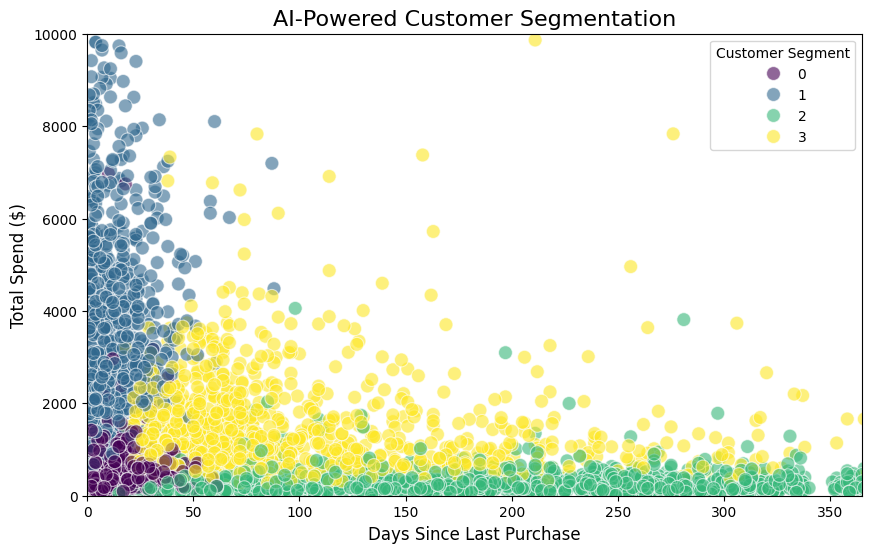

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

print("🎨 Generating Project Visualization...")

# 1. Setup the canvas
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Monetary',
    hue='Cluster',
    palette='viridis',
    s=100,
    alpha=0.6
)

plt.title('AI-Powered Customer Segmentation', fontsize=16)
plt.xlabel('Days Since Last Purchase', fontsize=12)
plt.ylabel('Total Spend ($)', fontsize=12)
plt.legend(title='Customer Segment')


plt.ylim(0, 10000)
plt.xlim(0, 365)

plt.savefig("customer_segments.png", dpi=300)
print("✅ Chart saved as 'customer_segments.png'")

plt.show()

/tmp/ipython-input-3313060936.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x=x, y=y, ax=ax, palette='viridis')
/tmp/ipython-input-3313060936.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x=x, y=y, ax=ax, palette='viridis')
/tmp/ipython-input-3313060936.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x=x, y=y, ax=ax, palette='viridis')


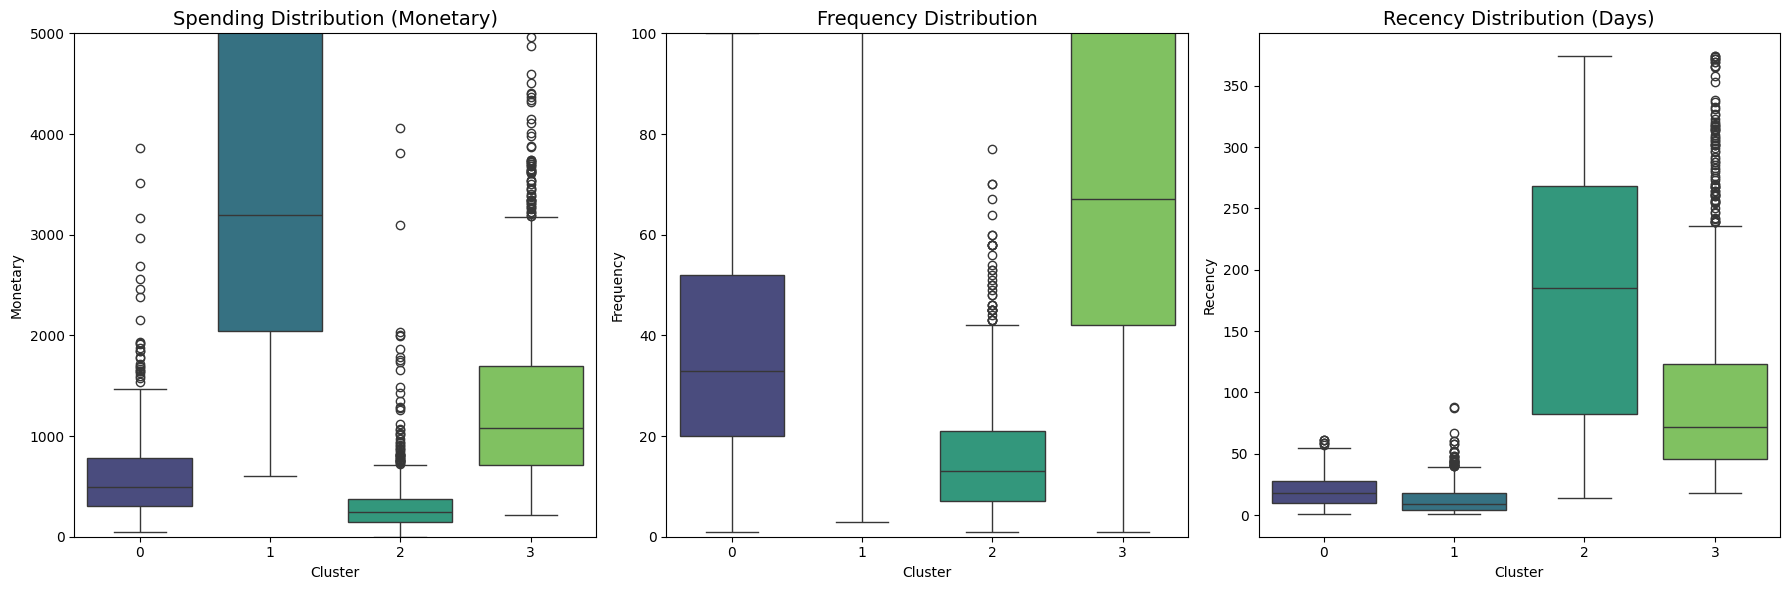

✅ Saved 'cluster_boxplots.png'


In [6]:
# --- VISUALIZATION 3: Behavioral Box Plots ---

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

def create_boxplot(x, y, ax, title):
    sns.boxplot(data=rfm, x=x, y=y, ax=ax, palette='viridis')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Cluster')

create_boxplot('Cluster', 'Monetary', axes[0], 'Spending Distribution (Monetary)')
axes[0].set_ylim(0, 5000)

create_boxplot('Cluster', 'Frequency', axes[1], 'Frequency Distribution')
axes[1].set_ylim(0, 100) # Zoom in

create_boxplot('Cluster', 'Recency', axes[2], 'Recency Distribution (Days)')

plt.tight_layout()
plt.savefig("cluster_boxplots.png", dpi=300)
plt.show()

print("✅ Saved 'cluster_boxplots.png'")